In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn as ml
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

Data preparation

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv')
print(data.head(5)) # first glance

# get dummy variables for relevant variables
data['Category'].unique() # check category codes
data = data[data.Category != '0s=suspect Blood Donor'] # dropping suspect blood donors (7 values only)
data['Sex'].unique() # check sex notation
data = pd.get_dummies(data, columns=['Sex', 'Category']) # get dummies for gender and categories
data = data.drop(['Unnamed: 0','Sex_m'], axis = 1) # drop unused columns 
# rename columns
data = data.rename(columns={'Category_0=Blood Donor': 'Healthy', 
                            'Category_1=Hepatitis': 'Hepatitis', 
                            'Category_2=Fibrosis': 'Fibrosis', 
                            'Category_3=Cirrhosis': 'Cirrhosis', 
                            'Sex_f': 'Female'}) 

data.dtypes # observe variables type

# missing values per variable
data.isnull().sum() # ALP and CHOL particularly affected

# sorting of the columns
data.columns[0:11]
data = data[['Healthy','Hepatitis','Fibrosis','Cirrhosis','Female', 'Age', 'ALB', 
          'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']]
print(data.head(5)) # show after preparation

Exporting data for R

In [ ]:

# export the data for imputation in R
data.to_csv('./data_prep.txt', 
            header = True, index = None, sep=' ', na_rep = 'NA')

We imputed missing data by using R and reloaded csv data again 

In [4]:
# load imputed data from R
data = pd.read_csv('./data_imp.csv')

# check structure
print(data.head(5)) 
data.head(5).to_latex() # export in latex

data.describe() # features summary
data['Healthy'].value_counts() # 533/608 Healthy 
data.isnull().sum() # no missing values anymore

# X is the matrix with features
X = data.iloc[:, 4:16] # select only the relevant columns from data
features = list(X.columns) # saving features names
X = np.array(X) # convert to numpy array

# we only predict healthy or not healthy
y = np.array(data['Healthy']) # y are the values we want to predict

# train-test split 50-50
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
n = X_train.shape[0] # number of observations in train and test samples


   Healthy  Hepatitis  Fibrosis  Cirrhosis  Female  Age   ALB   ALP   ALT  \
0        1          0         0          0       0   32  38.5  52.5   7.7   
1        1          0         0          0       0   32  38.5  70.3  18.0   
2        1          0         0          0       0   32  46.9  74.7  36.2   
3        1          0         0          0       0   32  43.2  52.0  30.6   
4        1          0         0          0       0   32  39.2  74.1  32.6   

    AST   BIL    CHE  CHOL   CREA   GGT  PROT  
0  22.1   7.5   6.93  3.23  106.0  12.1  69.0  
1  24.7   3.9  11.17  4.80   74.0  15.6  76.5  
2  52.6   6.1   8.84  5.20   86.0  33.2  79.3  
3  22.6  18.9   7.33  4.74   80.0  33.8  75.7  
4  24.8   9.6   9.15  4.32   76.0  29.9  68.7  


 Model estimations: starting points without ML techniques

Naive accuracy score =  0.8586
Linear probability model accuracy score =  0.9079


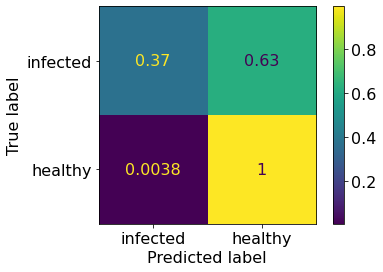

In [5]:
# naive prediction accurancy
npa = np.mean(y_test)
print('Naive accuracy score = ', round(npa,4))
scores = pd.DataFrame([['Naive Prediction', round(npa,4)]]) # save scores

# first starting point without ML techniques: linear probability model
lpm = LinearRegression().fit(X_train, y_train)
y_pred = lpm.predict(X_test)

# obtain classifier from linear probability model
for k in range(n):
    if y_pred[k] < 0.5: # = 0 if P(y=1) < 0.5
        y_pred[k] = 0
    else:
        y_pred[k] = 1 # = 1 if P(y=1) >= 0.5

# linear probability model scores 
lpma = accuracy_score(y_test, y_pred)
print('Linear probability model accuracy score = ', round(lpma,4))
scores = scores.append([['Linear Probability', round(lpma,4)]]) # save scores

# confusion matrix
plt.rcParams['font.size'] = '16'

cmlpm = confusion_matrix(y_test, y_pred, normalize='true') # type I and type II errors
disp = ConfusionMatrixDisplay(confusion_matrix = cmlpm, display_labels=('infected', 'healthy'))
disp.plot()


Logistic regression without ML techniques

Logistic regression accuracy score =  0.9375


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


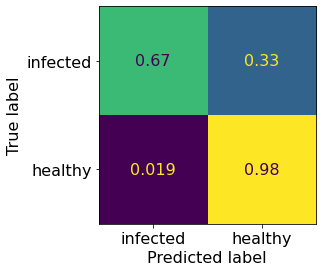

In [6]:
lr = LogisticRegression(random_state=42, penalty='none', max_iter=10000, solver='saga').fit(X_train, y_train)

# use X_test to construct the prediction 
y_pred = lr.predict(X_test) 

# scores
lra = accuracy_score(y_test, y_pred)
print('Logistic regression accuracy score = ', round(lra,4))
scores = scores.append([['Logistic Regression', round(lra,4)]]) # save scores

plot_confusion_matrix(lr, X_test, y_test, display_labels=('infected', 'healthy'), normalize='true', colorbar = False,) # confusion matrix


Model estimations: different logistic regressions with ML techniques

Polynomial logistic regression accuracy score and p order =  0.9375 ,  1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Lasso logistic regression accuracy score and optimal C-value =  0.9474 [3.]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Ridge logistic regression accuracy score and optimal C-value =  0.9572 ,  [0.3]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


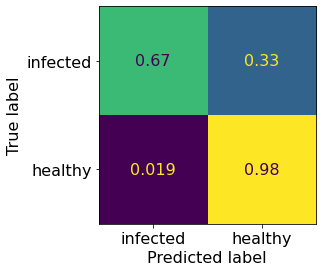

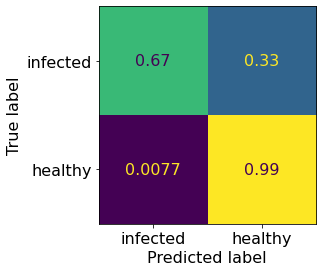

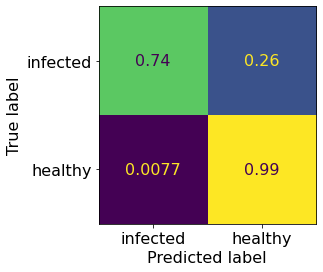

In [7]:

# polynomial (p) logistic regression with cross validation for p and p_max=3 (no penatly yet)
plr_cvs = []

# loop over p
for p in range(1,4): # make use of a pipeline to estimate different models for p = 1,2,3
    polyreg = make_pipeline(
        PolynomialFeatures(degree=p),
        LogisticRegression(random_state=42, penalty='none', max_iter=10000, solver='saga'))
    cvs = cross_val_score(polyreg, X_train, y_train, cv=8, scoring='accuracy')
    plr_cvs.append([p, np.mean(cvs)])

# a df with p orders and cross-validation scores
plr_cvs = pd.DataFrame(plr_cvs, columns=['polynomial', 'accuracy'])
# to select the p with highest cross-validation score
p_opt= plr_cvs['polynomial'].values[plr_cvs.idxmax()[1]]

# model estimation and evaluation with chosen p_optimal
polyreg = make_pipeline(
        PolynomialFeatures(degree=p_opt),
        LogisticRegression(random_state=42,penalty='none', max_iter=10000, solver='saga')
        )

# fit the model to the train sample
plr = polyreg.fit(X_train, y_train)

# predict the test sample outcome
y_pred = plr.predict(X_test)

# scores
plra = accuracy_score(y_test, y_pred)
print('Polynomial logistic regression accuracy score and p order = ', round(plra,4),', ', p_opt)
scores = scores.append([['Polynomial (1) Logistic Regression ', round(plra,4)]]) # save scores

# confusion matrix
plot_confusion_matrix(plr, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

# logistic regression (p=3) with Lasso penalty (l1) and cross-validation for C value
# C value determines the strengh of the regularization penalty (like lambda in the lectures)
# iterative tuning of C value was necessary (starting point: default values in the package)
# LogisticRegressionCV does the cross-validation for C automatically

Cs = np.arange(1.5,3.1,0.1) # tuning values

# pipeline
lassolr = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LogisticRegressionCV(Cs=Cs,random_state=42, penalty='l1', max_iter=10000, solver='saga', cv=8, scoring='accuracy'))

llr = lassolr.fit(X_train, y_train) # fit
y_pred = llr.predict(X_test) # predict

# scores
llra = accuracy_score(y_test, y_pred)
print('Lasso logistic regression accuracy score and optimal C-value = ', round(llra,4), llr._final_estimator.C_)
scores = scores.append([['Lasso Logistic Regression', round(llra, 4)]])

# confusion matrix
plot_confusion_matrix(llr, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

# logistic regression (p=3) with Ridge penalty (l2) and cross-validation for C value
# C value determines the strengh of the regularization penalty (like lambda in the lectures)
# iterative tuning of C value was necessary (starting point: default values in the package)
# LogisticRegressionCV does the cross-validation for C automatically

Cs = np.arange(0.3,0.51,0.01) # tuning values
ridgelr = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LogisticRegressionCV(Cs=Cs,random_state=42, penalty='l2', max_iter=10000, solver='saga', cv=8, scoring='accuracy'))

rlr = ridgelr.fit(X_train, y_train) # fit
y_pred = rlr.predict(X_test) # predict

rlra = accuracy_score(y_test, y_pred)
print('Ridge logistic regression accuracy score and optimal C-value = ', round(rlra,4), ', ', rlr._final_estimator.C_)
scores = scores.append([['Ridge Logistic Regression', round(rlra, 4)]])

# confusion matrix
plot_confusion_matrix(rlr, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

Model estimations: trees and random forests

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Basic Tree =  0.9309
Weighted Tree =  0.9145


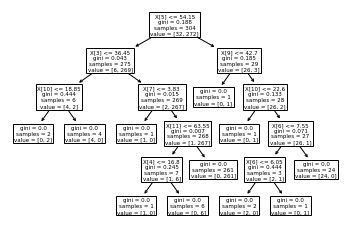

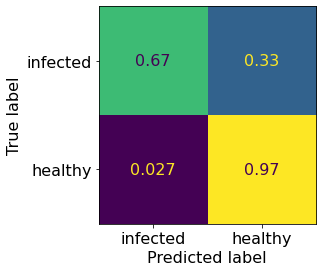

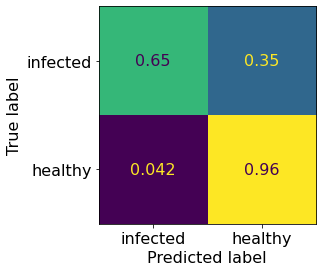

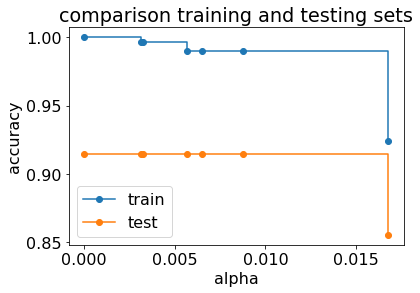

Weigthed Pruned Tree =  0.9408


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[Text(0.625, 0.875, 'AST <= 54.15\nsamples = 304\nvalue = [32, 272]\nclass = Healthy'),
 Text(0.5, 0.625, 'ALP <= 36.45\nsamples = 275\nvalue = [6, 269]\nclass = Healthy'),
 Text(0.25, 0.375, 'GGT <= 18.85\nsamples = 6\nvalue = [4, 2]\nclass = Infected'),
 Text(0.125, 0.125, 'samples = 2\nvalue = [0, 2]\nclass = Healthy'),
 Text(0.375, 0.125, 'samples = 4\nvalue = [4, 0]\nclass = Infected'),
 Text(0.75, 0.375, 'CHE <= 3.83\nsamples = 269\nvalue = [2, 267]\nclass = Healthy'),
 Text(0.625, 0.125, 'samples = 1\nvalue = [1, 0]\nclass = Infected'),
 Text(0.875, 0.125, 'samples = 268\nvalue = [1, 267]\nclass = Healthy'),
 Text(0.75, 0.625, 'samples = 29\nvalue = [26, 3]\nclass = Infected')]

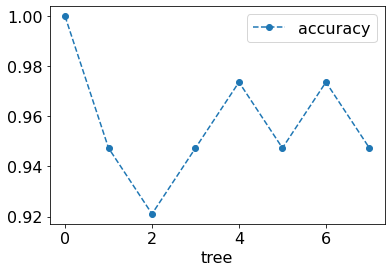

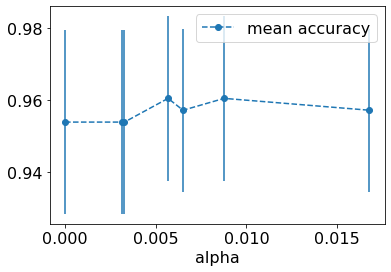

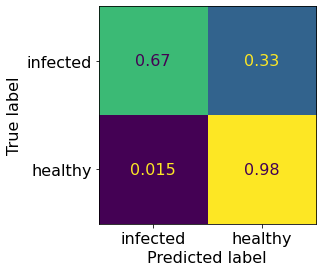

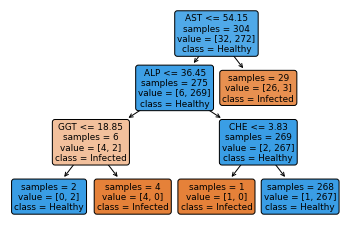

In [8]:
# a decision tree, train-test equal split
tt_tree = DecisionTreeClassifier(random_state = 42) # no weights
tt_tree.fit(X_train, y_train) # fit to data

# plot tt_tree
plt.figure()
tree.plot_tree(tt_tree) # plot unpruned tree

# confusion matrix
plot_confusion_matrix(tt_tree, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,)

# trees offer a completely differnt approach for the estimation 
# and could achieve completely different results

# score
y_pred = tt_tree.predict(X_test) # predict
ttt = accuracy_score(y_test, y_pred)
print('Basic Tree = ', round(ttt, 4))
scores = scores.append([['Basic Tree', accuracy_score(y_test, y_pred)]])

# weigthing for trees
# we check the performance of different weight ratio to see how the model reacts to  them
tt_tree_w5 = DecisionTreeClassifier(random_state = 42, class_weight={0:5, 1:1}) # 5:1 weights
tt_tree_w10 = DecisionTreeClassifier(random_state = 42, class_weight={0:10, 1:1}) # 10:1 weights
tt_tree_w50 = DecisionTreeClassifier(random_state = 42, class_weight={0:50, 1:1}) # 50:1 weights
tt_tree_w100 = DecisionTreeClassifier(random_state = 42, class_weight={0:100, 1:1}) # 100:1 weights
tt_tree_w500 = DecisionTreeClassifier(random_state = 42, class_weight={0:500, 1:1}) # 500:1 weights

# fit different weights 
tt_tree_w5.fit(X_train, y_train) 
tt_tree_w10.fit(X_train, y_train) 
tt_tree_w50.fit(X_train, y_train) 
tt_tree_w100.fit(X_train, y_train) 
tt_tree_w500.fit(X_train, y_train)

# predict with different weigths
y_pred_w5 = tt_tree_w5.predict(X_test)
y_pred_w10 = tt_tree_w10.predict(X_test)
y_pred_w50 = tt_tree_w50.predict(X_test)
y_pred_w100 = tt_tree_w100.predict(X_test)
y_pred_w500 = tt_tree_w500.predict(X_test)

# confusion matrices
confusion_matrix(y_test, y_pred_w5)
confusion_matrix(y_test, y_pred_w10)
confusion_matrix(y_test, y_pred_w50)
confusion_matrix(y_test, y_pred_w100)
confusion_matrix(y_test, y_pred_w500)

# trees perform better with lower weight ratios, the optimal value is somewhere 
# between 5 and 10, higher ratio tends to indentify false negatives more accurately, 
# we then opt for 10 as the optimal weightas: we want to put more emphasys on 
# classifing riskier observations by staying within this range.

# best weighted tree score

plot_confusion_matrix(tt_tree_w10, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,)

w_tree = accuracy_score(y_test, y_pred_w10)
print('Weighted Tree = ', round(w_tree, 4))
scores = scores.append([['Weighted Tree', accuracy_score(y_test, y_pred)]])


# the optimal weight found in this section will prove to be consistent among 
# the tree family of models it will then be used for random forests as well

#############
# tree puning

# tree reduction is done throught a cost complexity pruning, the paramater that 
# controls the depth of the pruning is the complexity parameter alpha
# greater the value of alpha the more nodes will be pruned. The pruning algorithm 
# recursively finds the node with the weakest link, or lower alpha and prunes it.

# cost-complexity pruning
path = tt_tree.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas # cost complexity parameters
alphas = alphas[:-1] # exclude last alpha, the one-node tree 

# create a decision tree for each alpha
trees = [] # array collect a decision trees for each alpha
# loop over alphas coming from the pruning path
for alpha in alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha = alpha, class_weight={0:10, 1:1})
    tree.fit(X_train, y_train)
    trees.append(tree)
    
# check their scores both in the train and the test
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

# plot alpha performance for the train sample and the test sample
fig, ax = plt.subplots()
ax.set_xlabel(("alpha"))
ax.set_ylabel("accuracy")
ax.set_title("comparison training and testing sets")
ax.plot(alphas, train_scores, marker='o', label='train', drawstyle = 'steps-post')
ax.plot(alphas, test_scores, marker='o', label='test', drawstyle = 'steps-post')
ax.legend()
plt.show()

# highest alpha for the test sample somewhere between 0.003 and 0.005
# we check the sensitivity of the accuracy to the particular sample with cross validation 
# if case of large divergence, some is to be expected also due to the relative small incidence of 1s

# check the sensibility of alpha to the sample used
tree_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = 0.01)
cv_scores = cross_val_score(tree_pruned, X_train, y_train, cv=8)

# plot the accuracy value for each subsample 
df = pd.DataFrame(data={'tree': range(8), 'accuracy': cv_scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--') 

# alpha is sensitive to the datasets, cross validation most appropriate

# create a decision tree for each alpha with cross validation
alpha_cv = [] # array collecting accurance scores with cross validation for each alpha

# loop over alpha
for alpha in alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha = alpha)
    alpha_scores = cross_val_score(tree, X_train, y_train, cv = 8) # cross validation scores
    alpha_cv.append([alpha, np.mean(alpha_scores), np.std(alpha_scores)])

# data frame with value of alpha, mean accuracy and its standard deviation
alpha_results = pd.DataFrame(alpha_cv, columns=['alpha', 'mean accuracy', 'std'])

# corresponding plot
alpha_results.plot(x='alpha', y='mean accuracy', yerr = 'std', marker = 'o', linestyle = '--')

# locate optimal value
alpha_results.idxmax() # 3rd alpha has the highest mean accuracy
optimal_alpha = alpha_results['alpha'].values[3] # save highest alpha value as optimal

# pruned tree construction with the optimal alpha obtained
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha = optimal_alpha)
pruned_tree = pruned_tree.fit(X_train, y_train)

# pruned tree score
y_pred = pruned_tree.predict(X_test)
pttt = accuracy_score(y_test, y_pred)
print('Weigthed Pruned Tree = ', round(pttt, 4))
scores = scores.append([['Pruned Weighted Tree', round(pttt, 4)]]) # 94.08% lower the the unpruned tree

# confusion
plot_confusion_matrix(pruned_tree, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

# plot optimal tree
plt.figure()
plot_tree(pruned_tree, rounded = True, class_names = ['Infected', 'Healthy'], feature_names = features, filled=True, impurity=False)
# pruned tree is much smaller and easy to comprehend and it delivers more accuracy

Random forest

Weighted Random Forest =  0.9539


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


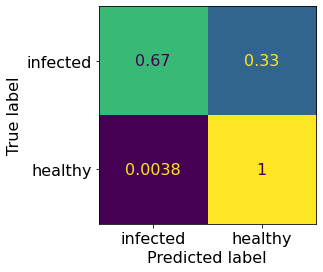

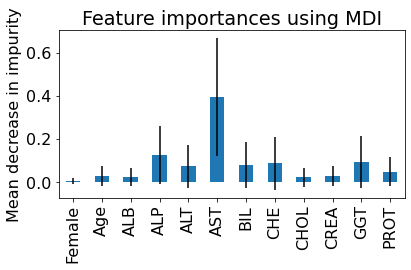

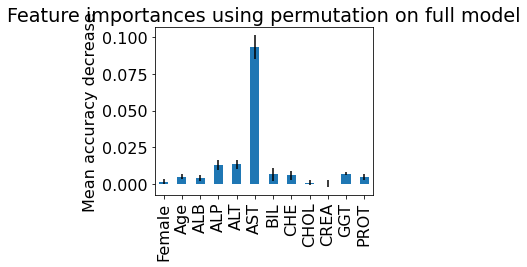

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
 'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [1000, 5000, 10000]}
Fitting 8 folds for each of 10 candidates, totalling 80 fits
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 5000}
Best Forest =  0.9539


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


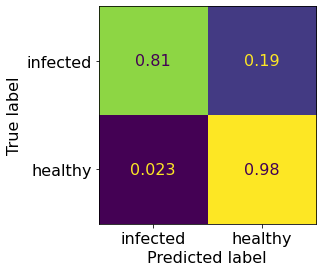

In [10]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42)
forest_w5 = RandomForestClassifier(n_estimators = 1000, random_state = 42, class_weight={0:5, 1:1})
forest_w10 = RandomForestClassifier(n_estimators = 1000, random_state = 42, class_weight={0:10, 1:1})
forest_w20 = RandomForestClassifier(n_estimators = 1000, random_state = 42, class_weight={0:20, 1:1})

# fit
forest.fit(X_train, y_train)
forest_w5.fit(X_train, y_train)
forest_w10.fit(X_train, y_train)
forest_w20.fit(X_train, y_train)

# predictions 
y_pred = forest.predict(X_test)
y_pred_w5 = forest_w5.predict(X_test)
y_pred_w10 = forest_w10.predict(X_test)
y_pred_w20 = forest_w20.predict(X_test)

# confusions 
confusion_matrix(y_test, y_pred)
confusion_matrix(y_test, y_pred_w5)
confusion_matrix(y_test, y_pred_w10)
confusion_matrix(y_test, y_pred_w20)

# between 5 and 10 the optimal weights, we will use 10 for the same reasoning 
# of the previous tree weighting

rf_w10 = accuracy_score(y_test, y_pred_w10)
print('Weighted Random Forest = ', round(rf_w10, 4))
scores = scores.append([['Weighted Random Forest', round(rf_w10, 4)]])

plot_confusion_matrix(forest, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

# feature importance based on mean decrease in impurity
# the attribute feature_importances_ from the model specification provides the feature importances
# computed as the mean and standard deviation of the accumulated impurity decrease within each tree.

importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot importances with corresponding standard deviation
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# the permutation feature importance is defined to be the decrease in a model score 
# when a feature is randomly removed from the expenatory variables, a drop in the model score
# is indicative of the relevance of the feature for the model prediction

perm_imp = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(perm_imp.importances_mean, index=features)

# plot permutation importances with corresponding standard deviation
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=perm_imp.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


####### REDUCED
# reduce features only to the important ones according to the permutation ranking
# X_important = pd.DataFrame(data, columns = ['AST', 'ALP', 'BIL', 'CHE']) 

# train-test split with important features
# X_train_imp, X_test_imp,  y_train_imp, y_test_imp = train_test_split(X_important, y, test_size = 0.5, random_state = 42)

# forest.fit(X_train_imp, y_train_imp)

# make prediction forest with importancies
# y_pred = forest.predict(X_test_imp)
# scores = scores.append([['Reduced Forest', accuracy_score(y_test_imp, y_pred)]]) # 94.4% for the reduced forest

# tt_tree.fit(X_train_imp, y_train_imp)
# y_pred = tt_tree.predict(X_test_imp) # use X_test to construct the prediction 
# scores = scores.append([['Reduced Tree', accuracy_score(y_test_imp, y_pred)]]) # 93.42 for the reduced tree

#######

# random search with cross validation among a combination of different parameters
n_estimators = [1000, 5000, 10000] # increase the number of estimators
# different option for the max number of features to consider, from 3 to all of them
max_features = [int(x) for x in np.linspace(3, len(features), 10)] 
max_depth = [int(x) for x in np.linspace(2, 30, 15)] # tree depths 
min_samples_split = [2, 3, 4, 5, 6, 7, 8] # minimum number of samples required to split a node
min_samples_leaf = [2, 3, 4, 5, 6, 7, 8] # minimum number of samples required at each leaf node
bootstrap = [True, False] # Bagging and not

# Create the random search 
forest_search = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# check the grid with options
pprint(forest_search)

# in this case we use RandomizedSearchCV() the parameters of the estimator
# are optimized by cross-validated search over parameter settings, we use 
# neg_mean_absolute_error as searching method, beacuse the obsective is to find 
# a range of suitable estimators

# random search across the different combinations
forest_random = RandomizedSearchCV(forest_w10, param_distributions = forest_search,
                              n_iter = 10, cv = 8, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# fit
forest_random.fit(X_train, y_train)

# best_params_ is the estimator that gives the highest score gives highest score 

# save specifications
pprint(forest_random.best_params_) # observe best estimator parameters
best_forest = forest_random.best_estimator_
y_pred = best_forest.predict(X_test)
bfg = accuracy_score(y_test, y_pred)
print('Best Forest = ', round(bfg, 4))
plot_confusion_matrix(forest_random.best_estimator_, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

Best hyper-params for random forest estimator

Fitting 8 folds for each of 1 candidates, totalling 8 fits
{'bootstrap': True,
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 5000}
Best Forest =  0.9638


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


'\\begin{tabular}{llr}\n\\toprule\n{} &                                    0 &         1 \\\\\n\\midrule\n0 &                     Naive Prediction &  0.858600 \\\\\n0 &                   Linear Probability &  0.907900 \\\\\n0 &                  Logistic Regression &  0.937500 \\\\\n0 &  Polynomial (1) Logistic Regression  &  0.937500 \\\\\n0 &            Lasso Logistic Regression &  0.947400 \\\\\n0 &            Ridge Logistic Regression &  0.957200 \\\\\n0 &                           Basic Tree &  0.930921 \\\\\n0 &                        Weighted Tree &  0.930921 \\\\\n0 &                 Pruned Weighted Tree &  0.940800 \\\\\n0 &               Weighted Random Forest &  0.953900 \\\\\n0 &                          Best Forest &  0.963800 \\\\\n\\bottomrule\n\\end{tabular}\n'

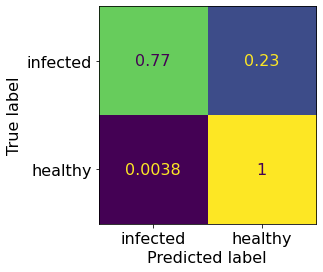

In [11]:
# after three iterations of the code in the section where we look for a range 
# (-1, 0, +1) around each parameter in the last best performing grid

# now seach for each element in the grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [5],
    'max_features': [2],
    'min_samples_leaf': [4],
    'min_samples_split': [2],
    'n_estimators': [5000]
}

# random_state needed as the search goes over all possible combinations of param_grid

grid_search = GridSearchCV(estimator = forest_w10, param_grid = param_grid,
                           cv = 8, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
  
# final fit
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_ # save best forest so far
y_pred = best_grid.predict(X_test)
bfg = accuracy_score(y_test, y_pred)
print('Best Forest = ', round(bfg, 4))

plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test, display_labels=('infected','healthy'), normalize='true', colorbar = False,) # confusion matrix

######
######

# best forest scores
scores = scores.append([['Best Forest', round(bfg, 4)]])

# print final scores
scores.to_latex() # export in latex